In [162]:
import pickle
import warnings
import maya

import numpy as np
import pandas as pd

from tqdm import tqdm
from glob import glob
from collections import OrderedDict
from datetime import datetime as dt

from sklearn import decomposition, manifold

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [85]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_rows = 200

In [5]:
embeds, rows = [], []

for path in tqdm(glob('../data/b13-embeds/*.p')):
    with open(path, 'rb') as fh:
        
        lines = pickle.load(fh)

        for line in lines:
            title = ' '.join(line.pop('tokens'))
            embeds.append(line.pop('embedding'))
            rows.append(OrderedDict(title=title, **line))

100%|██████████| 99/99 [00:40<00:00,  2.25it/s]


In [6]:
embeds = np.stack(embeds)

In [7]:
df = pd.DataFrame(rows)

In [8]:
df.label.unique()

array(['dailycaller.com', 'thehill.com', 'bloomberg.com', 'breitbart.com',
       'buzzfeed.com', 'cnn.com', 'nytimes.com', 'apnews.com',
       'huffingtonpost.com', 'washingtonpost.com', 'wsj.com',
       'foxnews.com', 'dailykos.com'], dtype=object)

In [9]:
embeds.shape

(982833, 512)

In [128]:
df = df[df.first_ts > dt(2017, 1, 1).timestamp()]

In [129]:
df['p_true'] = df.apply(lambda r: r[f'p_{r.label}'], axis=1)

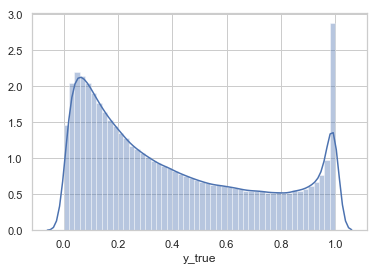

In [130]:
sns.distplot(df.y_true)

In [131]:
df['date'] = df.first_ts.apply(lambda ts: dt.fromtimestamp(ts).date())

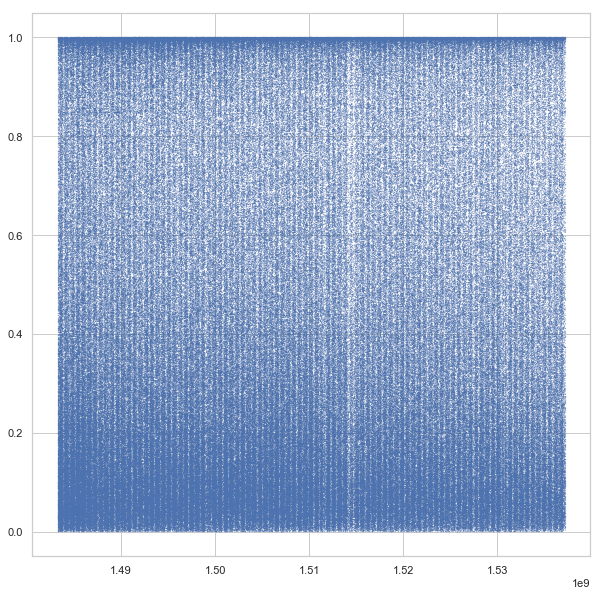

In [132]:
plt.figure(figsize=(10,10))
plt.scatter(df.first_ts, df.y_true, s=0.01)

In [133]:
mean_pt = df.groupby('date').mean()['p_true']

In [134]:
mean_pt.sort_index(inplace=True)

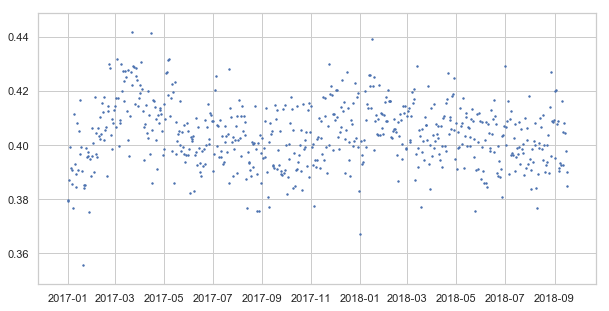

In [135]:
plt.figure(figsize=(10,5))
plt.scatter(mean_pt.index, mean_pt, s=2)

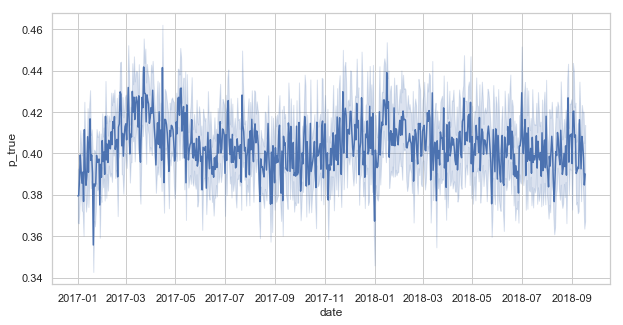

In [136]:
plt.figure(figsize=(10,5))
sns.lineplot(df.date, df.p_true, err_style='band')

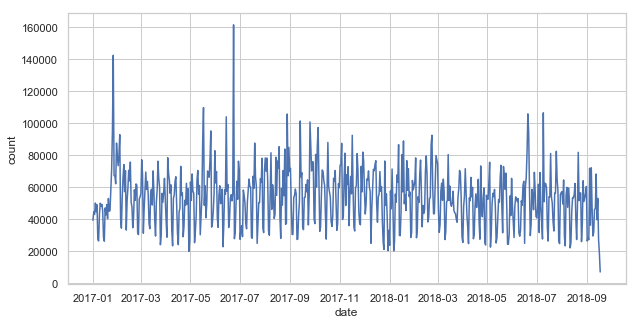

In [139]:
counts = df.groupby('date').sum()['count']
plt.figure(figsize=(10,5))
sns.lineplot(counts.index, counts)

dailycaller.com


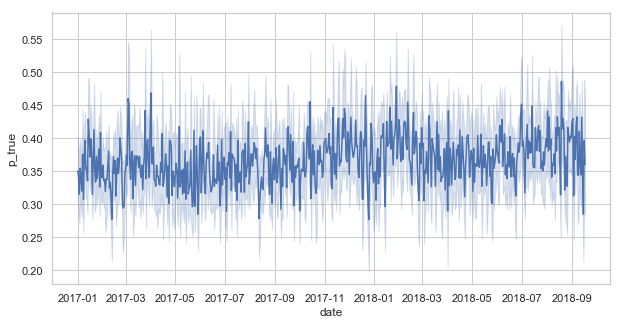

thehill.com


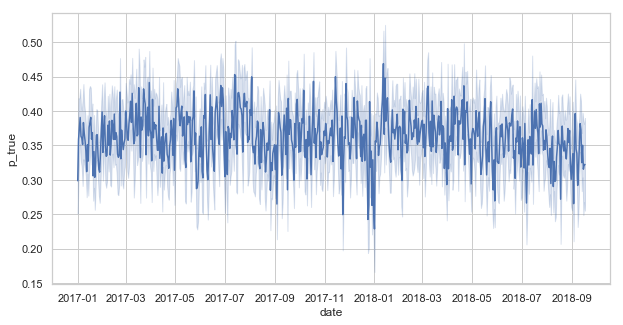

bloomberg.com


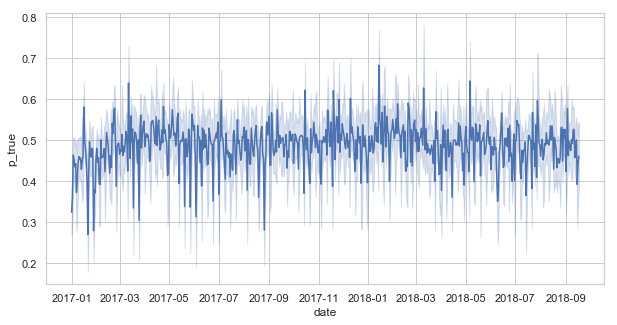

breitbart.com


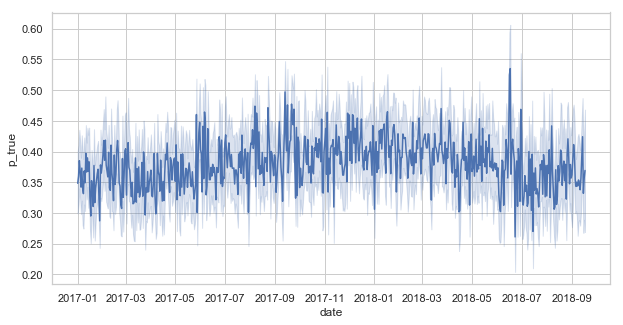

buzzfeed.com


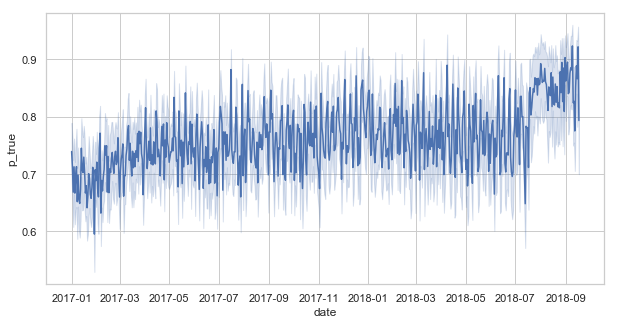

cnn.com


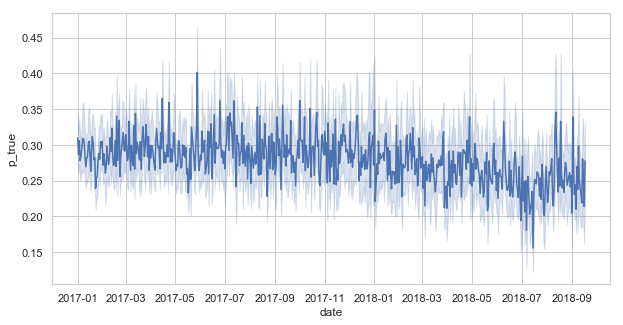

nytimes.com


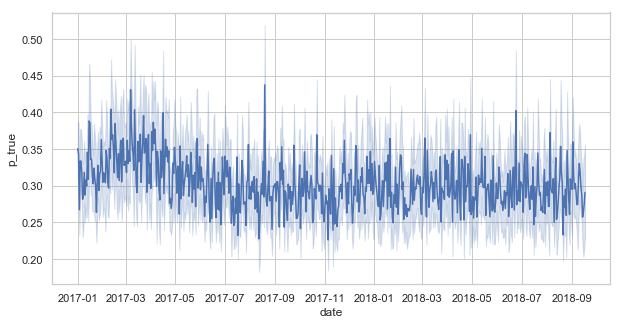

apnews.com


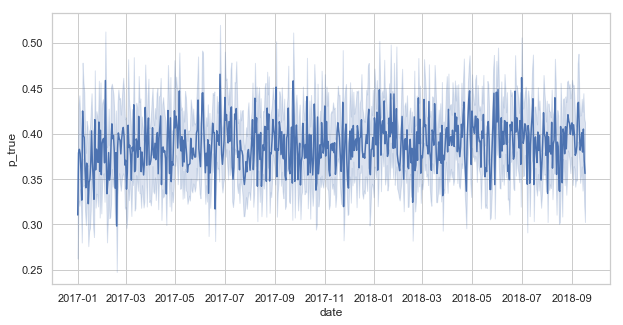

huffingtonpost.com


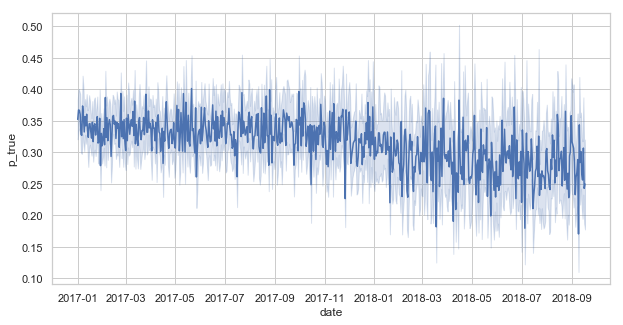

washingtonpost.com


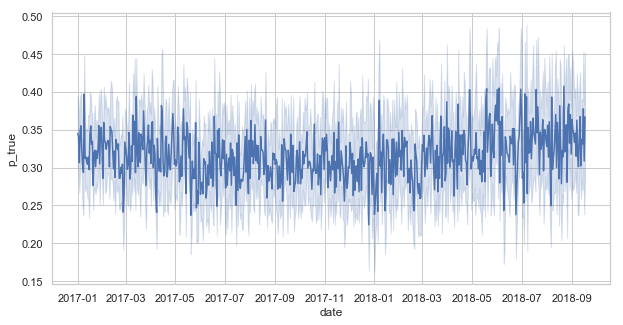

wsj.com


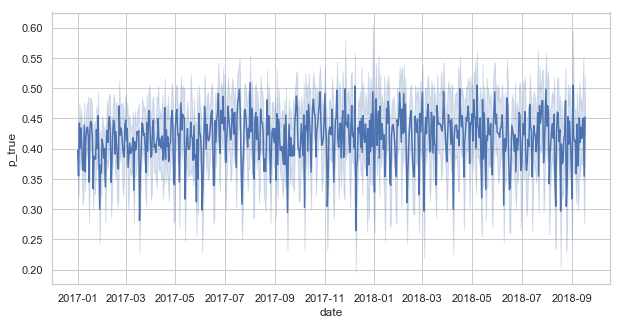

foxnews.com


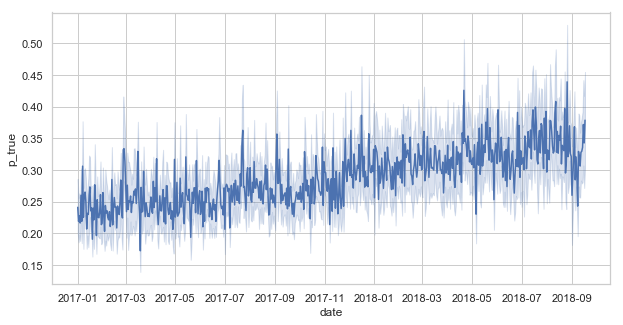

dailykos.com


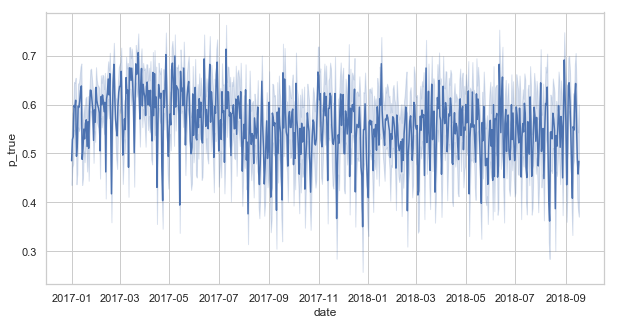

In [151]:
for d in df.label.unique():
    dfp = df[df.label==d]
    plt.figure(figsize=(10,5))
    print(d)
    sns.lineplot(dfp.date, dfp.p_true, err_style='band')
    plt.show()

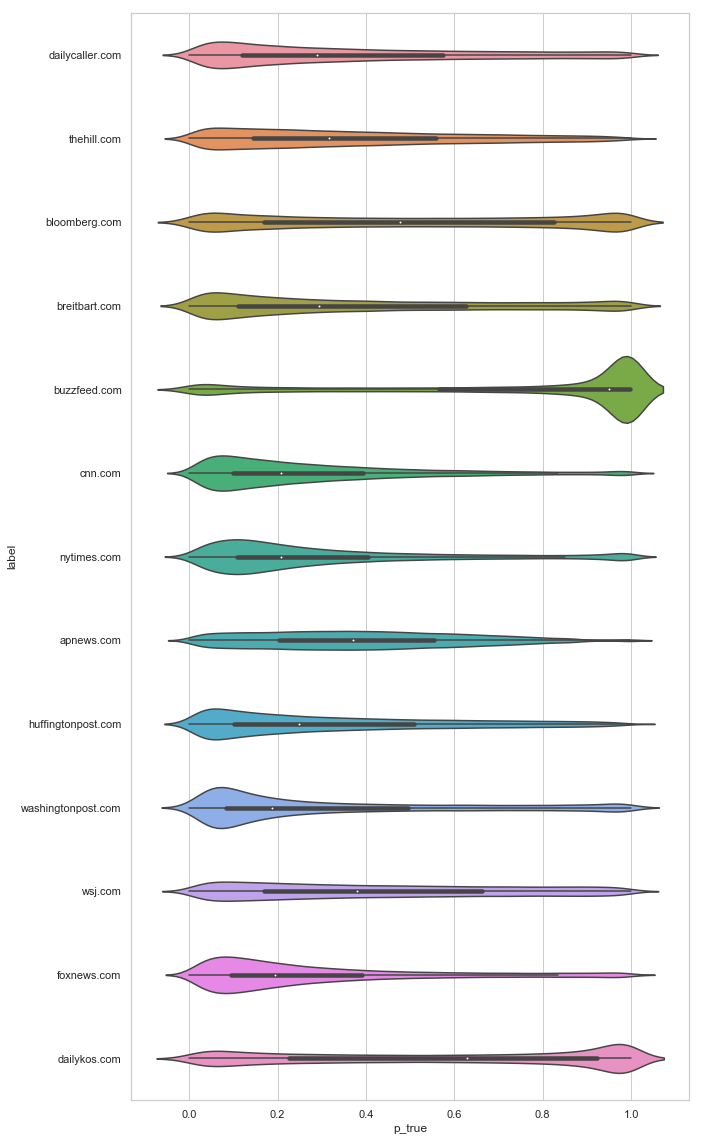

In [160]:
plt.figure(figsize=(10,20))
sns.violinplot(x='p_true', y='label', data=df)

In [195]:
# dfp = df[df.label.isin(['nytimes.com', 'foxnews.com', 'huffingtonpost.com'])]
dfp = df
dr = decomposition.TruncatedSVD(20)
embedding = dr.fit_transform(embeds[dfp.index])

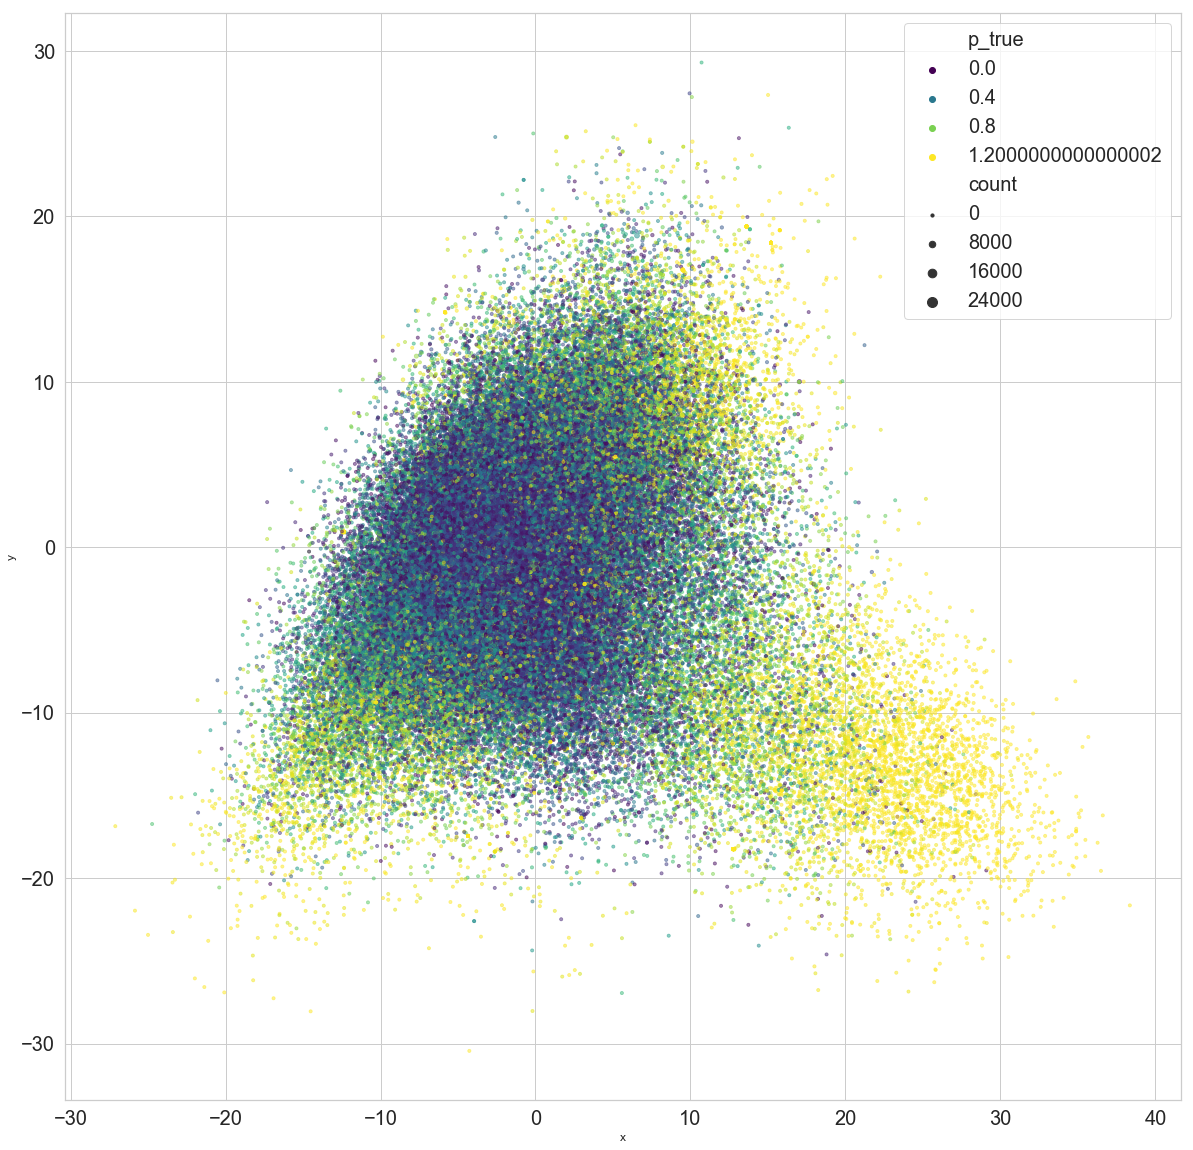

In [199]:
points = dfp.copy()
points['x'] = embedding[:,0]
points['y'] = embedding[:,1]

plt.figure(figsize=(20,20))

ax = sns.scatterplot(
    x='x', y='y',
    data=points.sample(frac=0.1),
    hue='p_true',
    edgecolor=None,
    size='count',
    sizes=(10, 100),
    alpha=0.5,
    palette='viridis'
)